# VALUTAZIONE XAI: NORMALIZZAZIONE DATI


## Azioni preliminari


### Importazione librerie

In [1]:
import shap
import numpy as np
import pandas as pd
import joblib
import os
import keras
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns


c:\Users\Gabriele\miniconda3\envs\codit2026\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Gabriele\miniconda3\envs\codit2026\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


### Caricamento del modello

In [2]:
channel_names = ["A", "B", "C", "DEG", "F", "H", "I", "J", "KL"]

# Carica il modello
MODEL_NAME = "HCNN_NormoDati_100Trials.h5"
MODEL_PATH = os.path.join("../01-MODELLI/", MODEL_NAME)

model = keras.models.load_model(MODEL_PATH, compile=False)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
model.summary()

shap.initjs()

#le dimensioni delle matrici di addestramento dell'explainer dovranno coincidere
#con le dimensioni dell'input della rete neurale


Model: "functional_91"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_183     │ (None, 45, 45, 9) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_273 (Conv2D) │ (None, 23, 23,    │      1,312 │ input_layer_183[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_364      │ (None, 23, 23,    │          0 │ conv2d_273[0][0]  │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 11, 11,    │          0 │ activation_364[0… │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_274 (Conv2D) │ (None, 6, 6, 8)   │      1,160 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_365      │ (None, 6, 6, 8)   │          0 │ conv2d_274[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 3, 3, 8)   │          0 │ activation_365[0… │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_275 (Conv2D) │ (None, 2, 2, 4)   │        292 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_366      │ (None, 2, 2, 4)   │          0 │ conv2d_275[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 1, 1, 4)   │          0 │ activation_366[0… │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_182     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_91          │ (None, 4)         │          0 │ average_pooling2… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_91      │ (None, 5)         │          0 │ input_layer_182[… │
│ (Concatenate)       │                   │            │ flatten_91[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_182 (Dense)   │ (None, 12)        │         72 │ concatenate_91[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_367      │ (None, 12)        │          0 │ dense_182[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_183 (Dense)   │ (None, 1)         │         13 │ activation_367[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,849 (11.13 KB)

 Trainable params: 2,849 (11.13 KB)

 Non-trainable params: 0 (0.00 B)

### Caricamento dataset

In [3]:
# Estrae i vari input/output dal training set
C_TRAIN_PATH = "../00-DATASET/C_train_norm.xlsx"
E_TRAIN_PATH ="../00-DATASET/E_train_norm.pkl"

C_train_df = pd.read_excel(C_TRAIN_PATH, header=None)       #(3652,1)
C_train_df = np.array(C_train_df).reshape(-1)               #(3652,)
E_train_pkl = joblib.load(E_TRAIN_PATH)                     #(3652, 45, 45, 9)

X_train = [C_train_df[:-1],E_train_pkl[:-1]]
y_train = C_train_df[1:]                                    #(3651,)

# Estrae i vari input/output dal validation set
C_VAL_PATH = "../00-DATASET/C_val_2020_2022_norm.xlsx"
E_VAL_PATH = "../00-DATASET/E_val_2020_2022_norm.pkl"

C_val_df = pd.read_excel(C_VAL_PATH, header=None)           #(1096, 1)
C_val_df = np.array(C_val_df).reshape(-1)                   #(1096,)
E_val_pkl = joblib.load(E_VAL_PATH)                         #(1096, 45, 45, 9)

X_val = [C_val_df[:-1],E_val_pkl[:-1]]
y_val = C_val_df[1:]                                        #(1095,)

# Utilizza un modello già addestrato per fare previsioni sui dati di validazione
y_pred = model.predict(X_val, verbose=0)  # verbose=0 evita la stampa del progresso

### Addestramento explainer SHAP

In [4]:
background = [
    X_train[0].reshape(X_train[0].shape[0], 1), 
    X_train[1]                               
] # uso l'intero training set come background -> pesante e non necessario ma ho una distribuzione più precisa
explainer = shap.DeepExplainer(model, background)

c:\Users\Gabriele\miniconda3\envs\codit2026\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


### Dati da spiegare e spiegazione

In [5]:
# carico l'intero validation set per spiegarlo
samples = [
    X_val[0].reshape(X_val[0].shape[0],1),          #NO2 puntuale                          
    X_val[1]                                        #NOx grigliato                
]

""" # Spiega samples
shap_values_tot = explainer.shap_values(samples)

print(shap_values_tot[0].shape)
print(shap_values_tot[1].shape) """

shap_values_tot = joblib.load("SHAP_Values_2020_2022.pkl")

### Verifica valori di SHAP

Gli shap values per una predizione indicano quanto ciascun input ha influito in tale predizione. Il modo in cui è misurata l'influenza di ciascun input è il contributo dell'input nell'allontanare la predizione dalla baseline (la media delle previsioni del modello calcolata sul background fornito). In formule:
$$
f(x) = E[f(x)] + \sum_{i=1}^{N} shap\_values_i
$$
Dove:
- $ f(x) $ è la predizione del modello per l'input $ x $
- $ E[f(x)] $ è il valore atteso del modello di solito calcolato come media sul background (baseline)
- $ N $ è il numero di input

Perciò, gli shap values si possono interpretare così

**Per input grigliati:**<br>
- Zona rossa -> se aumenti il valore di input in quella zona, allora l’output previsto dal modello tende ad aumentare.<br>
- Zona blu -> se aumenti il valore di input in quella zona, allora l’output previsto tende a diminuire.<br>

**Per input puntuali:**<br>
- Valori positivi → all'aumentare dell'input l'output aumenta.<br>
- Valori negativi → all'aumentare dell'input' l'output decrementa.<br>
- Valori vicini a 0 → input poco rilevante.<br>

In [6]:
s = 0
for x in shap_values_tot:
    s += np.sum(x[0, ..., 0])
pred = y_pred[0,0]
baseline = float(explainer.expected_value[0].numpy())


print("Somma SHAP:", s)
print("Predizione:", pred)
print("Baseline:", baseline)
print("SHAP + baseline =", s + baseline, "=> == predizione?", s + baseline - pred < 1e-6, "(fino almeno alla 6 cifra decimale)")

Somma SHAP: 0.3285295011911433
Predizione: 0.56495553
Baseline: 0.2364259958267212
SHAP + baseline = 0.5649554970178645 => == predizione? True (fino almeno alla 6 cifra decimale)


## Analisi spiegazione singolo sample

In [7]:
shap_C = shap_values_tot[0]
shap_E = shap_values_tot[1]


#### Scelta del giorno con plot

In [99]:
def plot_NO2(idx, y_pred, y_val):
    date_maxF = datetime.datetime(2020, 1, 2) + datetime.timedelta(days=int(idx))
    print(date_maxF)
    plt.figure()
    plt.plot(y_pred[idx - 15:idx + 15], label='Predicted NO2')
    plt.plot(y_val[idx - 15 - 1:idx + 15 - 1], label='Actual NO2')
    plt.axvline(x=15, color='r', linestyle='--')
    plt.legend()
    plt.show()

def plot_NOx(idx, X_val, unified_scale=False):
    plt.figure()
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    axs = axs.flatten()
    for i in range(9):
        axs[i].set_title(f'{channel_names[i]}')
        if unified_scale:
            axs[i].imshow(X_val[1][int(idx), :, :, i], cmap='viridis', vmin=0, vmax=1)
        else:
            axs[i].imshow(X_val[1][int(idx), :, :, i], cmap='viridis')
    plt.show()


def plot_heatmaps(idx, shap_E):
    scale_fct = np.max(np.abs(shap_E[idx, :, :, :, 0]))
    for j in range(3):  # Riga della griglia
        for k in range(3):  # Colonna della griglia
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 riga, 2 colonne

            # --- Heatmap con vmin/vmax fissati ---
            sns.heatmap(
                -1*shap_E[idx, :, :, j*3+k, 0],
                cmap = "bwr",
                annot=False,
                square=True,
                linewidths=0.5,
                linecolor="white",
                vmin=-scale_fct,
                vmax=scale_fct,
                ax=axes[0],
                cbar=True
            )
            axes[0].set_title(f"Fixed scale (sector {macrosectors[j*3+k]})", fontsize=18, fontweight='bold')

            # --- Heatmap con scala adattiva (senza vmin/vmax) ---
            sns.heatmap(
                -1*shap_E[idx, :, :, j*3+k, 0],
                cmap= "bwr",
                annot=False,
                square=True,
                linewidths=0.5,
                linecolor="white",
                vmin=-np.max(np.abs(shap_E[idx, :, :, j*3+k, 0])),
                vmax=np.max(np.abs(shap_E[idx, :, :, j*3+k, 0])),
                ax=axes[1],
                cbar=True
            )
            axes[1].set_title(f"Adaptive scale (sector {macrosectors[j*3+k]})", fontsize=18, fontweight='bold')

            plt.tight_layout()
            plt.savefig(f"Heatmap_Abs_{macrosectors[j*3+k]}_SingleSample.png", dpi=300)
            plt.show()


2022-01-15 00:00:00


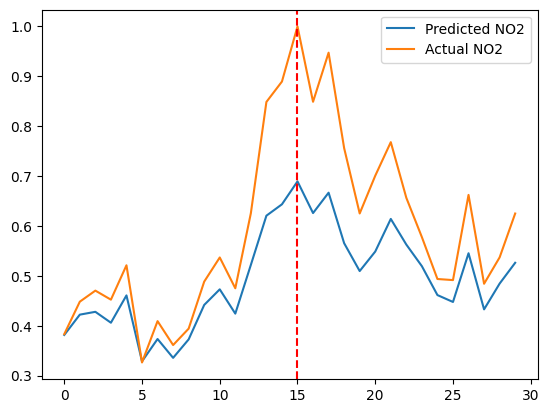

2021-07-27 00:00:00


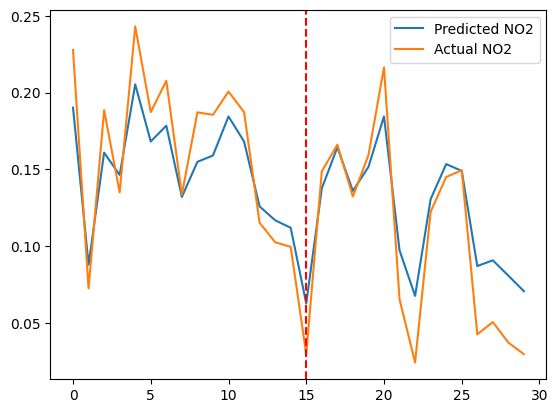

In [100]:
import datetime

idx_max = np.argmax(y_pred)
plot_NO2(idx_max, y_pred, y_val)

idx_min = np.argmin(y_pred)
plot_NO2(idx_min, y_pred, y_val)

idx_max_mean_Emissions = np.argmax(np.mean(X_val[1], axis = (1, 2, 3)))

<Figure size 640x480 with 0 Axes>

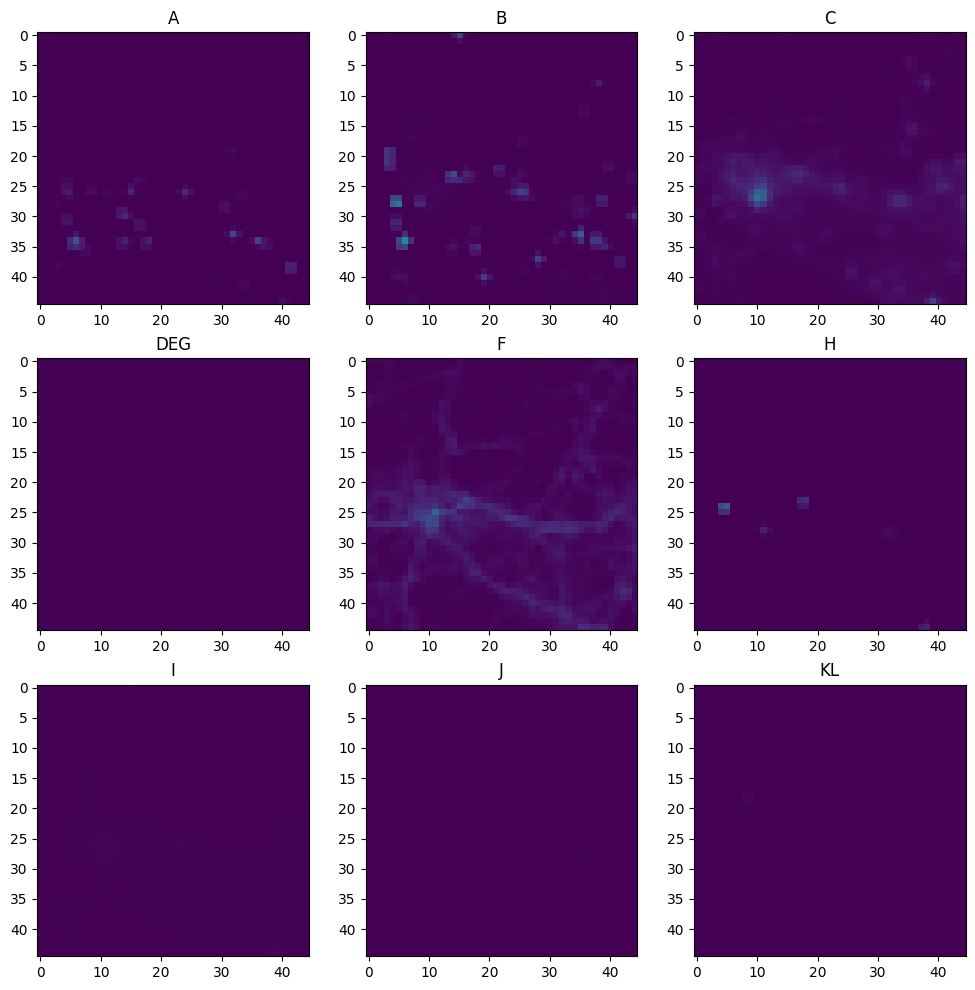

<Figure size 640x480 with 0 Axes>

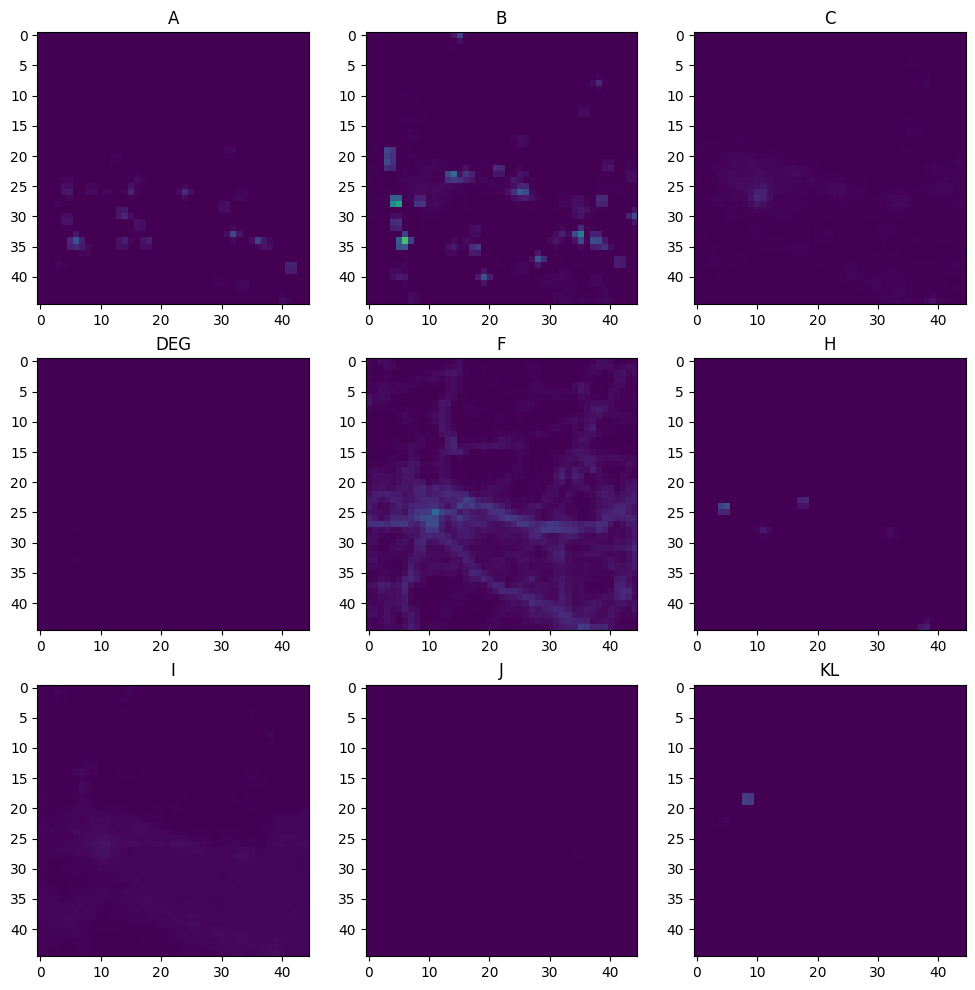

In [101]:
plot_NOx(idx_max, X_val, unified_scale=True)
plot_NOx(idx_min, X_val, unified_scale=True)

#### Analisi shap values

In [ ]:
def prepare_1d_shap_and_values(idx, shap_C, shap_E, X_val):
    feature_names = ["NO2","A", "B", "C", "DEG", "F", "H", "I", "J", "KL"]
    NO2_shap = shap_C[idx, ..., 0].reshape((1,1))
    NOx_shap=np.sum(shap_E[idx, ..., :,:,:], axis = (0, 1)) #(1095,9)
    all_shap_1d = np.concatenate([NO2_shap, NOx_shap], axis=0).reshape(10,)

    NO2_val=X_val[0].reshape(-1,1) #(1095,1)
    NO2_val = np.round(NO2_val[idx], 3)
    NOx_val= np.round(np.mean(X_val[1], axis=(1,2)), 3)#(1095,9)
    NOx_val = NOx_val[idx]
    all_val_1d = np.concatenate([NO2_val, NOx_val])

    return feature_names, all_shap_1d, all_val_1d

def plot_forceplot(idx, shap_C, shap_E, X_val, explainer):
    feature_names, all_shap_1d, all_val_1d = prepare_1d_shap_and_values(idx, shap_C, shap_E, X_val)
    fig = shap.plots.force(
        explainer.expected_value[0].numpy(),
        all_shap_1d,
        feature_names=feature_names,
        features=all_val_1d,
        matplotlib=True,
        show=False,
    )

    plt.savefig(
        "ForcePlot_SingleSample_MaxF.png",
        bbox_inches="tight",
        dpi=300
    )
    plt.show()

def plot_feature_importance(idx, shap_C, shap_E, X_val, explainer):
    feature_names, all_shap_1d, all_val_1d = prepare_1d_shap_and_values(idx, shap_C, shap_E, X_val)

    expl = shap.Explanation(
        values=all_shap_1d,
        base_values=explainer.expected_value[0].numpy(),
        data=all_val_1d,
        feature_names=feature_names
    )

    fig = shap.plots.bar(expl, show=False, show_data=False)
    """ plt.savefig(
        "FeatureImportance_SingleSample_MaxF.png",
        bbox_inches="tight",
        dpi=300
    ) """
    plt.show()

def plot_image_plots(idx_max, shap_E, X_val, channel_names, unified_scale=False):
    for i in range(8):
        shap.image_plot(
            shap_E[idx_max:idx_max+1, ..., i:i+1, :],
            X_val[1][idx_max:idx_max+1, ..., i:i+1],
            true_labels = ["Sector " + channel_names[i]],
            labels = ["SHAP values"],
            vmax = np.max(np.abs(shap_E[idx_max])) if unified_scale else None,
        )


Force plot

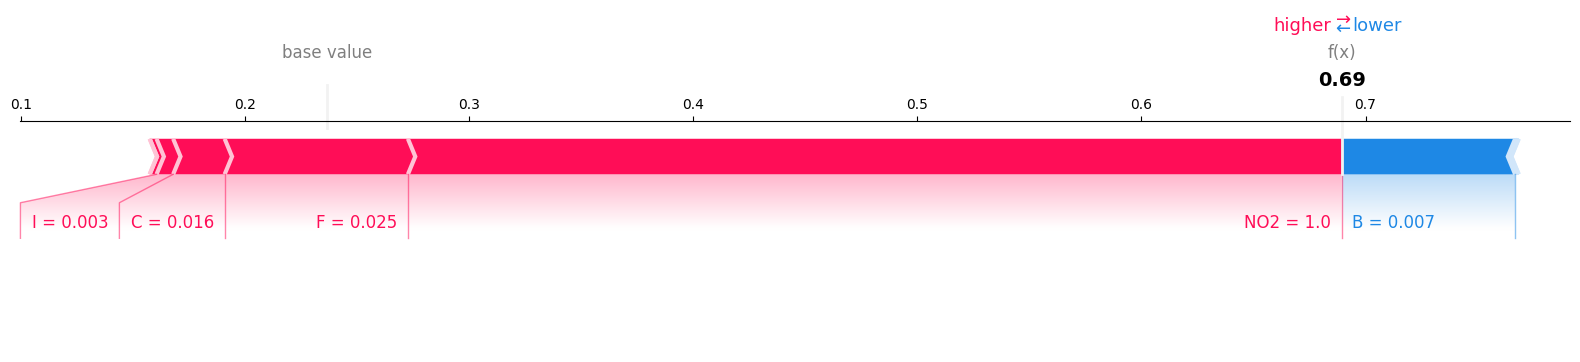

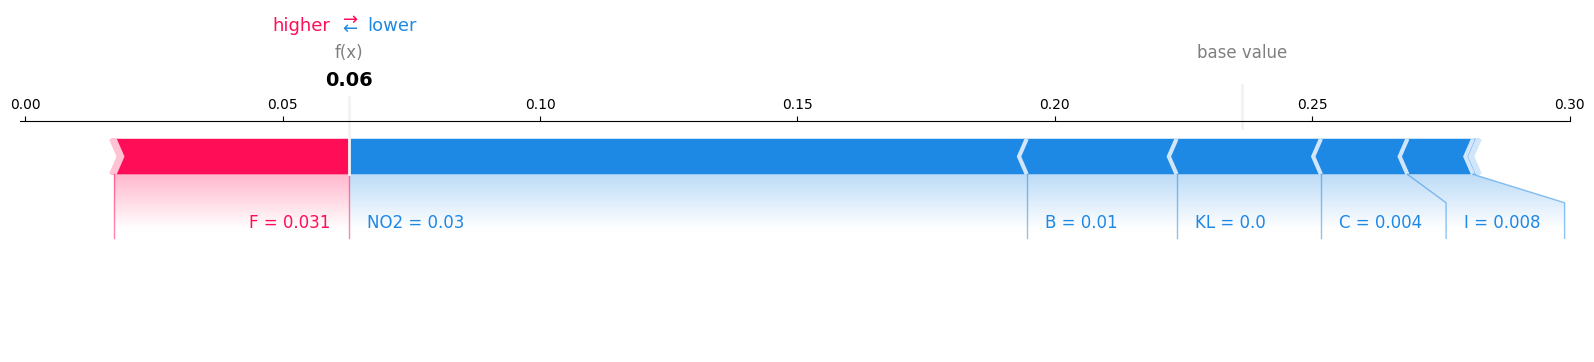

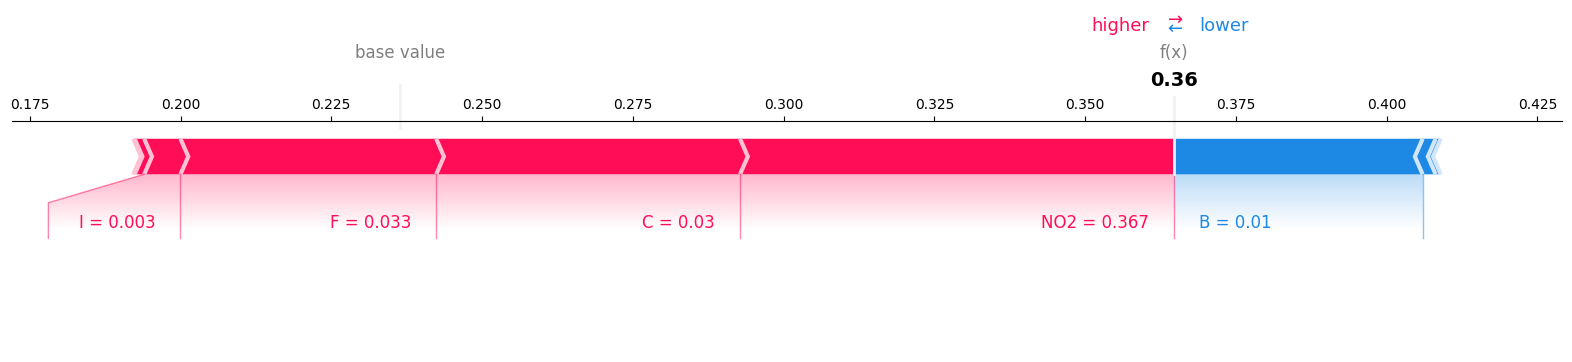

In [12]:
plot_forceplot(idx_max, shap_C, shap_E, X_val, explainer)
plot_forceplot(idx_min, shap_C, shap_E, X_val, explainer)
plot_forceplot(idx_max_mean_Emissions, shap_C, shap_E, X_val, explainer)

Feature importance

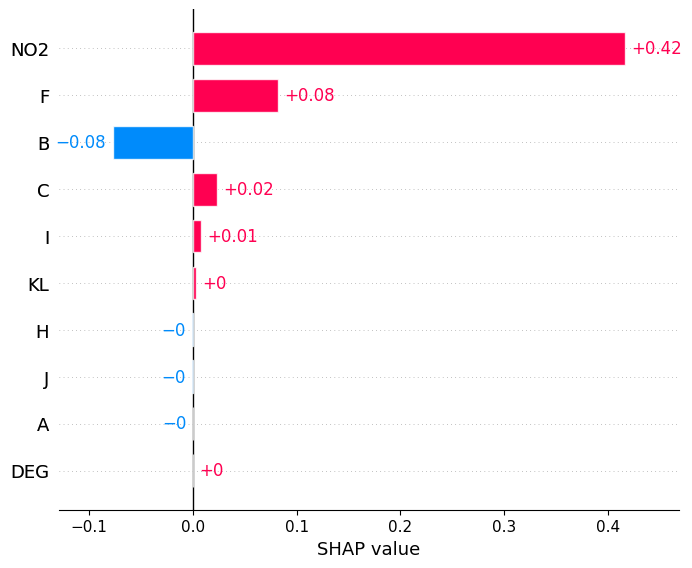

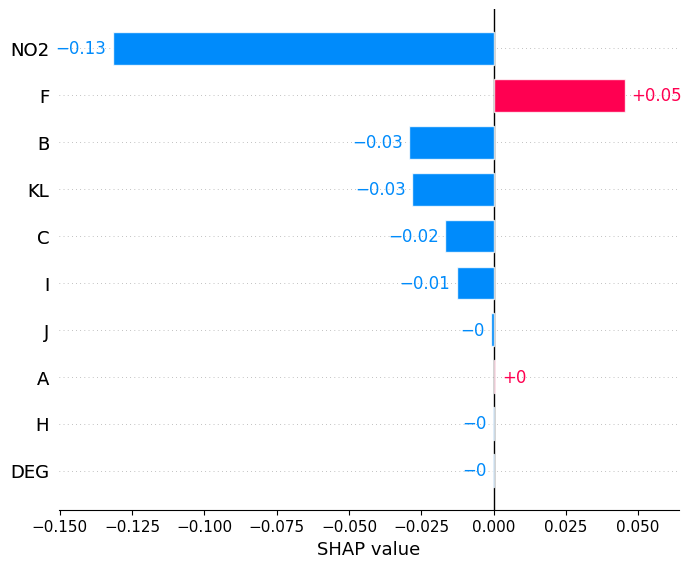

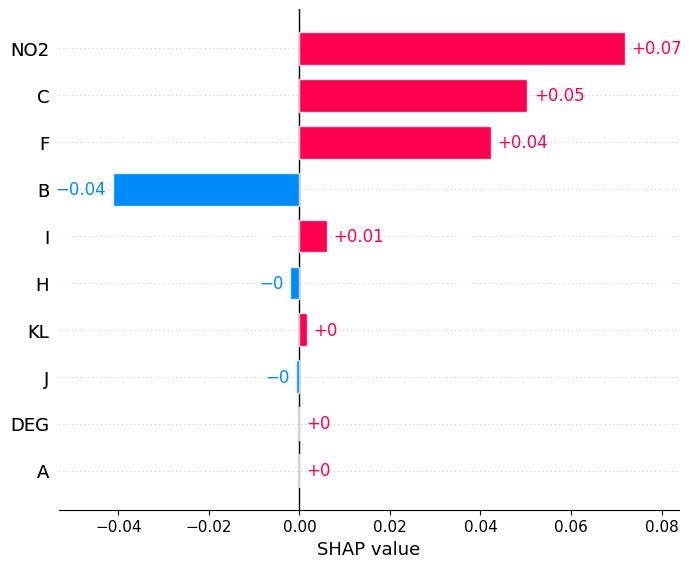

In [13]:
plot_feature_importance(idx_max, shap_C, shap_E, X_val, explainer)
plot_feature_importance(idx_min, shap_C, shap_E, X_val, explainer)
plot_feature_importance(idx_max_mean_Emissions, shap_C, shap_E, X_val, explainer)

Image plot

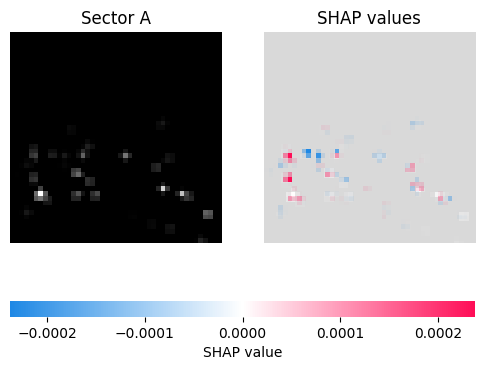

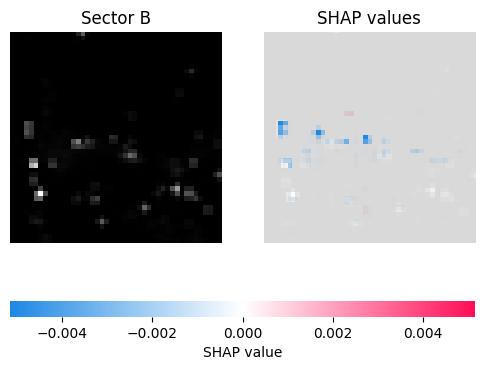

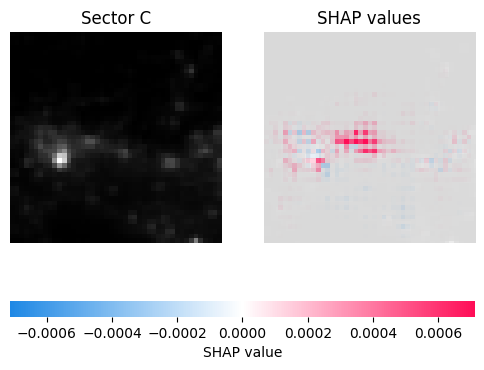

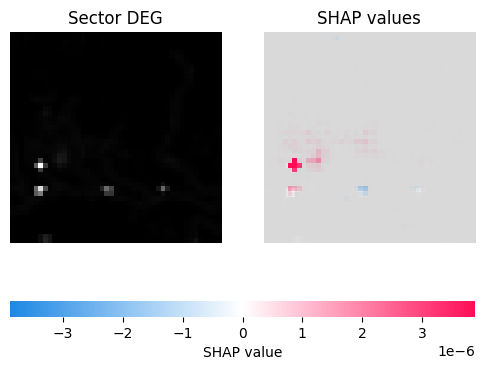

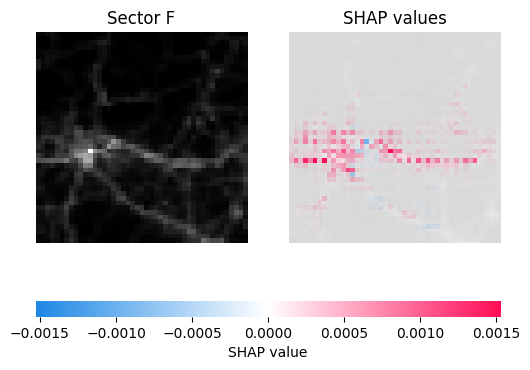

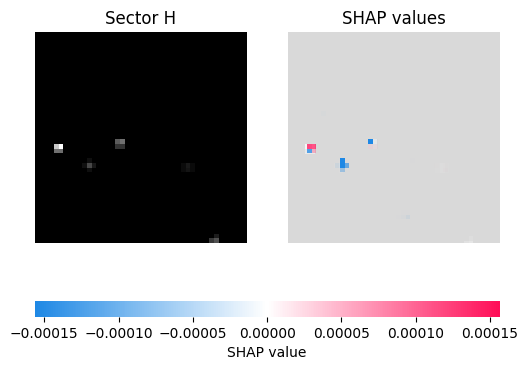

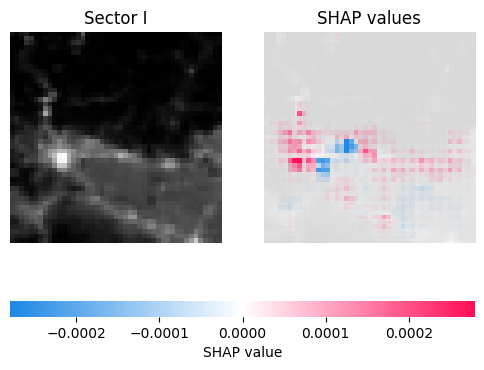

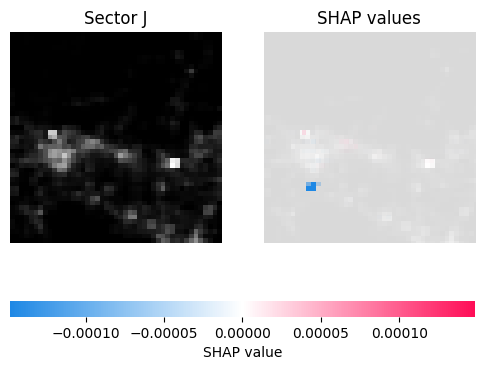

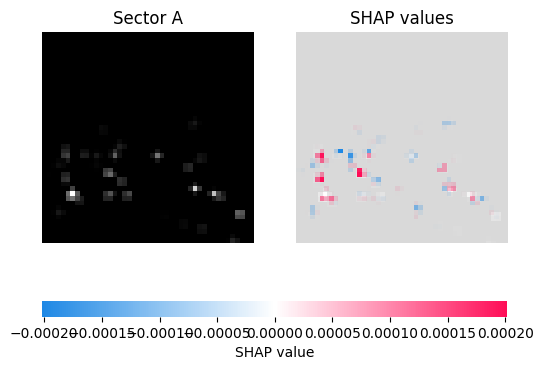

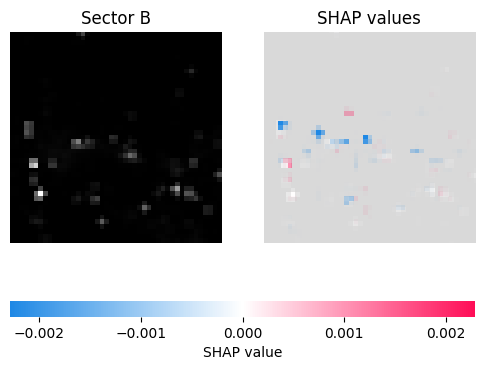

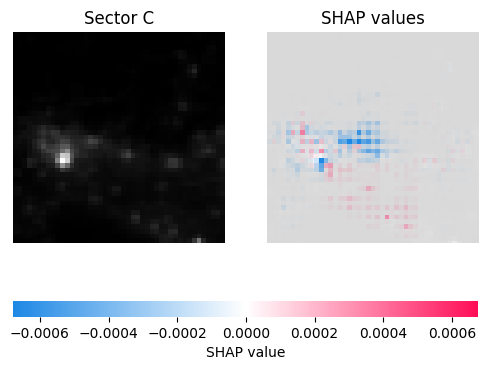

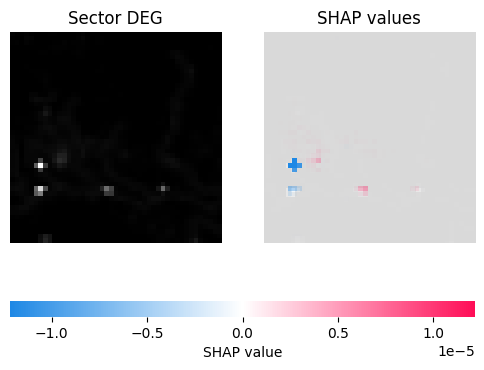

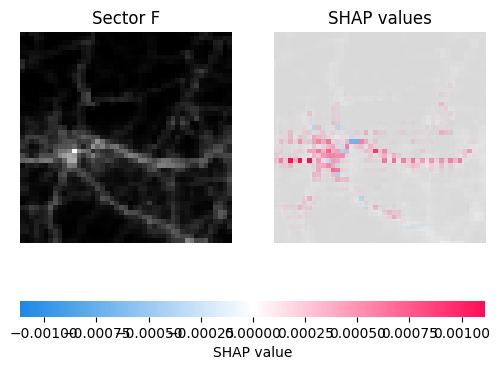

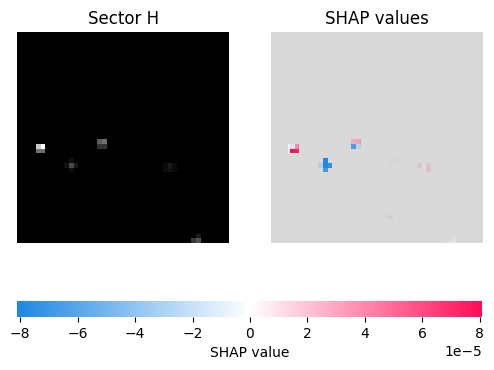

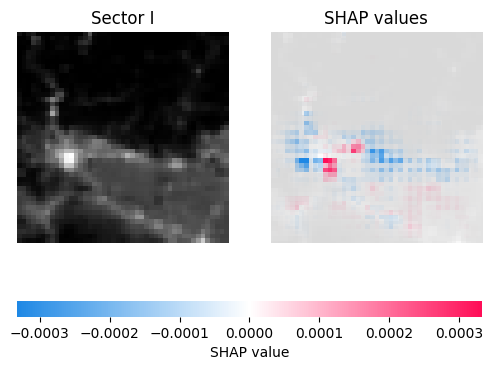

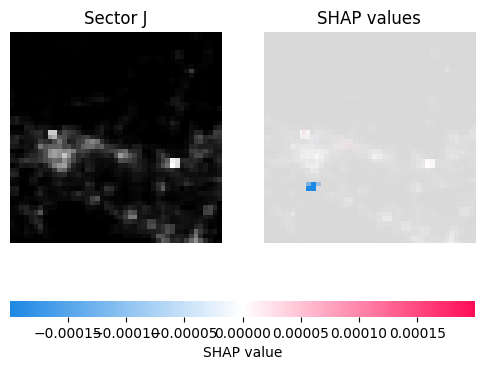

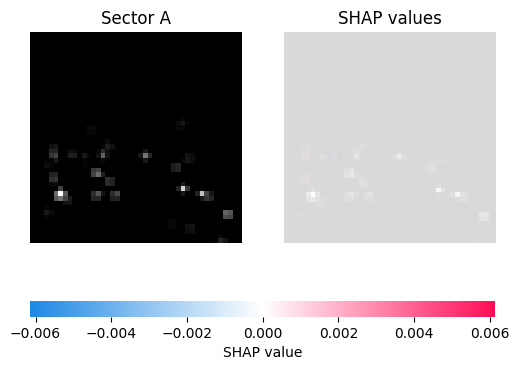

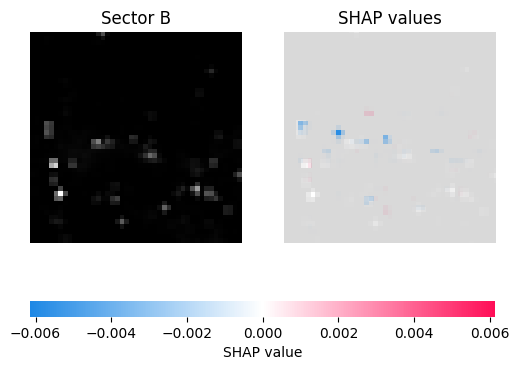

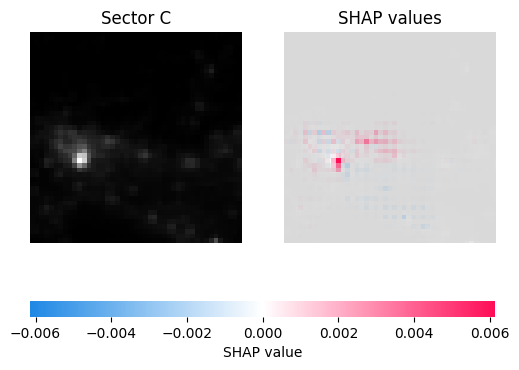

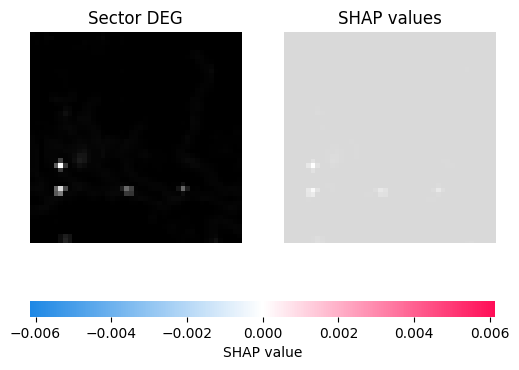

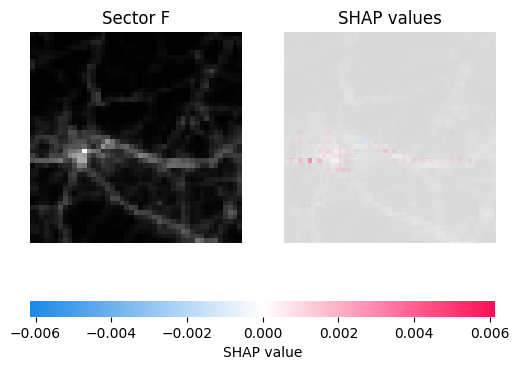

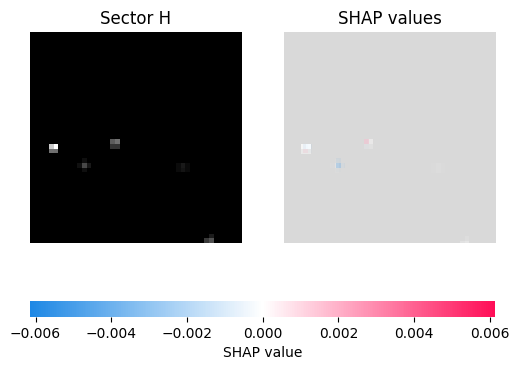

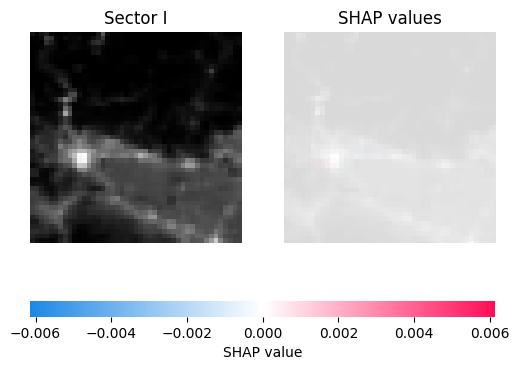

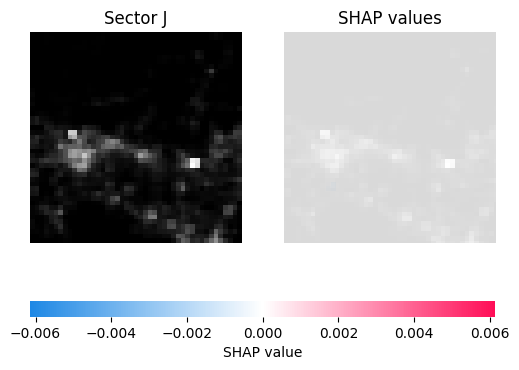

In [16]:
plot_image_plots(idx_max, shap_E, X_val, channel_names)
plot_image_plots(idx_min, shap_E, X_val, channel_names)
plot_image_plots(idx_max_mean_Emissions, shap_E, X_val, channel_names, unified_scale=True)

#### Variabilità degli input di NOx

Variabilità nei 3 anni di ciascun pixel vs shap values (media dei tre anni) diviso per macrosettore

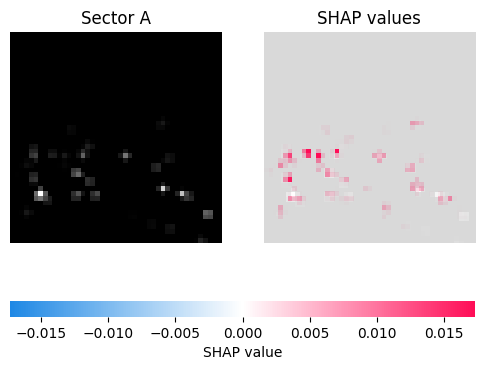

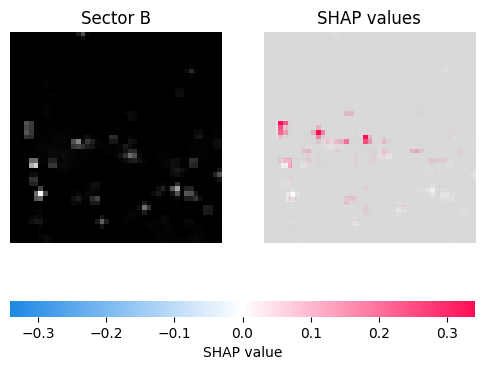

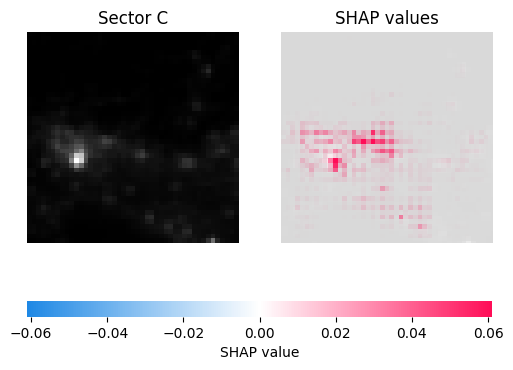

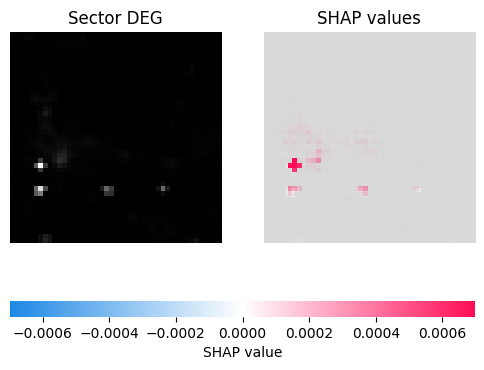

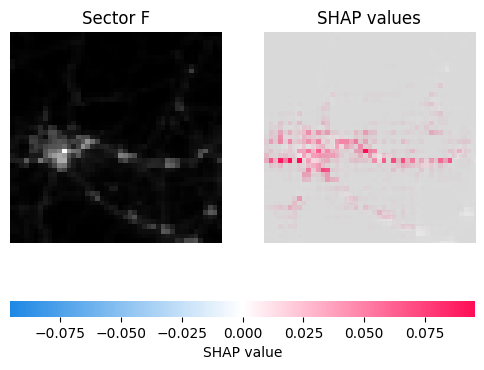

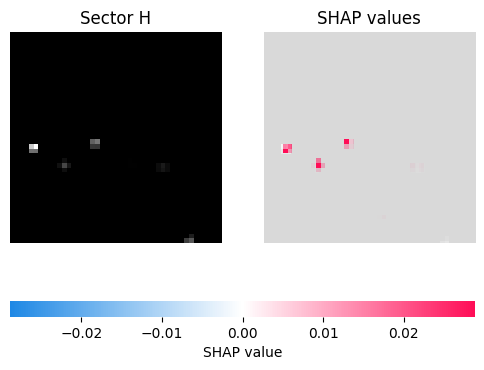

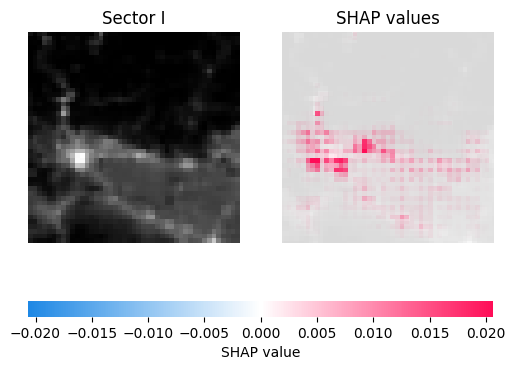

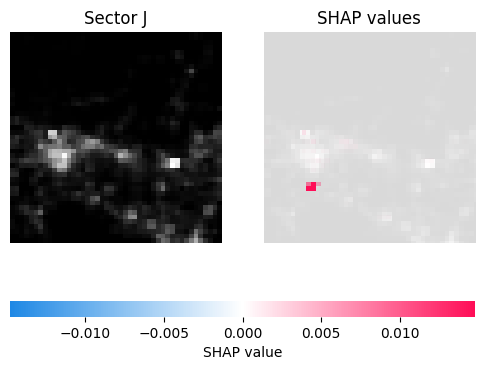

In [14]:
shap_abs_sum_emissions = np.mean(np.abs(shap_E), axis=(0)).reshape((1,45,45,9,1))
min, max = 8.56, 94.5397
shap_abs_sum_emissions = shap_abs_sum_emissions*(max - min)
values = np.std(X_val[1], axis=(0)).reshape((1,45,45,9))
plot_image_plots(0, shap_abs_sum_emissions, [0, values], channel_names, unified_scale=False)

Variabilità delle emissioni in ciascun pixel vs shap value (media sui tre anni della somma dei macrosettori di ciascun pixel)

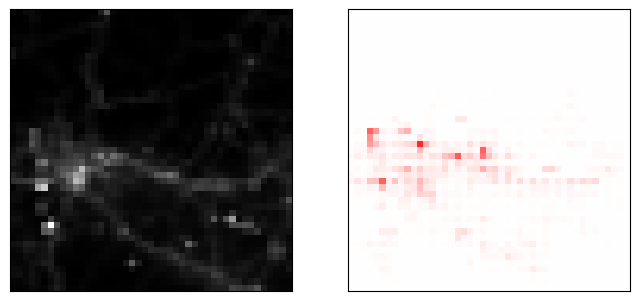

In [37]:
shap_abs_sum_emissions = np.mean(np.sum(np.abs(shap_E), axis = 3), axis=(0)).reshape((45,45,1))
min, max = 8.56, 94.5397
shap_abs_sum_emissions = shap_abs_sum_emissions*(max - min)
values = np.std(X_val[1], axis=(0,3)).reshape((45,45,1))

fig, ax = plt.subplots(1,2, figsize=(8,8))
ax[0].imshow(values, cmap = "grey")
ax[1].imshow(shap_abs_sum_emissions, cmap = "bwr", vmin = -(np.max(shap_abs_sum_emissions) + 0.1), vmax = np.max(shap_abs_sum_emissions) + .1)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

plt.savefig("../../figs/std_dev.png", bbox_inches="tight", dpi=300)

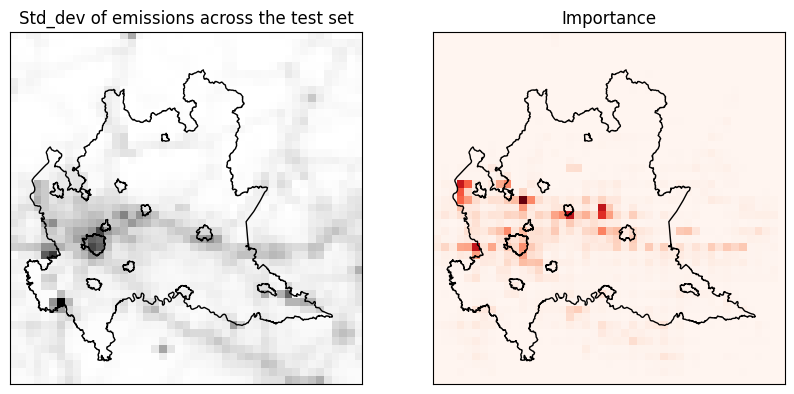

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from matplotlib.colors import LogNorm

# -------------------------------
# Dati
# -------------------------------
p1 = (450000, 4930000)
p2 = (714000, 5194000)

xmin, ymin = p1
xmax, ymax = p2

# SHP
gdf_shp = gpd.read_file("../../shape_files/Com01012025/Com01012025_WGS84.shp")
gdf_shp = gdf_shp[gdf_shp["COD_REG"] == 3]
capoluoghi = [
    "Milano", "Bergamo", "Brescia", "Como",
    "Cremona", "Lecco", "Lodi", "Mantova",
    "Monza", "Pavia", "Sondrio", "Varese"
]
df_lombardia = gdf_shp[(gdf_shp["COMUNE"].isin(capoluoghi))]

gdf_shp = gpd.read_file("../../shape_files/Reg01012025/Reg01012025_WGS84.shp")
gdf_shp = gdf_shp[gdf_shp["COD_REG"] == 3]

#gdf_shp = gdf_shp.to_crs(epsg=32633)  # 🔴 fondamentale

# -------------------------------
# Immagini
# -------------------------------
shap_abs_sum_emissions = np.mean(np.sum(np.abs(shap_E), axis=3), axis=0).reshape((45,45))
min_, max_ = 8.56, 94.5397
shap_abs_sum_emissions *= (max_ - min_)

values = np.std(X_val[1], axis=(0,3)).reshape((45,45))

# -------------------------------
# Plot
# -------------------------------
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# EXTENT collega pixel ↔ coordinate UTM
extent = [xmin, xmax, ymin, ymax]

ax[0].imshow(values[::-1, :], cmap="binary", extent=extent, origin="lower")
ax[1].imshow(
    1 + shap_abs_sum_emissions[::-1, :],
    cmap="Reds",
    extent=extent,
    origin="lower",
    #vmin=0,
    #vmax=np.max(shap_abs_sum_emissions),
    norm=LogNorm(
        vmin=1,
        vmax=np.max(shap_abs_sum_emissions)+1
    )
)
ax[0].set_title("Std_dev of emissions across the test set")
ax[1].set_title("Importance")
for a in ax:
    gdf_shp.boundary.plot(ax=a, color="black", linewidth=1)
    df_lombardia.boundary.plot(ax=a, color="black", linewidth=1)
    a.set_xticks([])
    a.set_yticks([])
    a.set_aspect("equal")

plt.savefig("../../figs/std_dev.png", bbox_inches="tight", dpi=300)
plt.show()


In [125]:
den_shap_E = shap_E * (max - min)

print(shap_E[0, 0, 0], den_shap_E[0, 0, 0])

[[ 0.00000000e+00]
 [ 5.18484581e-09]
 [-3.80526450e-07]
 [ 2.20087304e-10]
 [-6.83445175e-07]
 [ 0.00000000e+00]
 [-9.53998235e-08]
 [ 3.70048073e-10]
 [ 0.00000000e+00]] [[ 0.00000000e+00]
 [ 4.45791487e-07]
 [-3.27175500e-05]
 [ 1.89230404e-08]
 [-5.87624111e-05]
 [ 0.00000000e+00]
 [-8.20244820e-06]
 [ 3.18166223e-08]
 [ 0.00000000e+00]]


#### Aggregazione per quantili

c:\Users\Gabriele\miniconda3\envs\codit2026\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


Number of samples:  109
Force plot for the top 10% predicted NO2 values (avg of y_pred = 57.46138000488281):


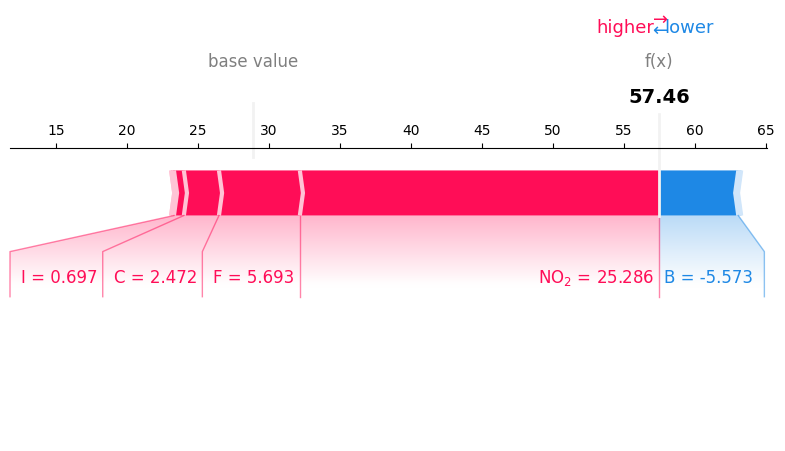

Force plot for the bottom 10% predicted NO2 values (avg of y_pred = 17.734264373779297):


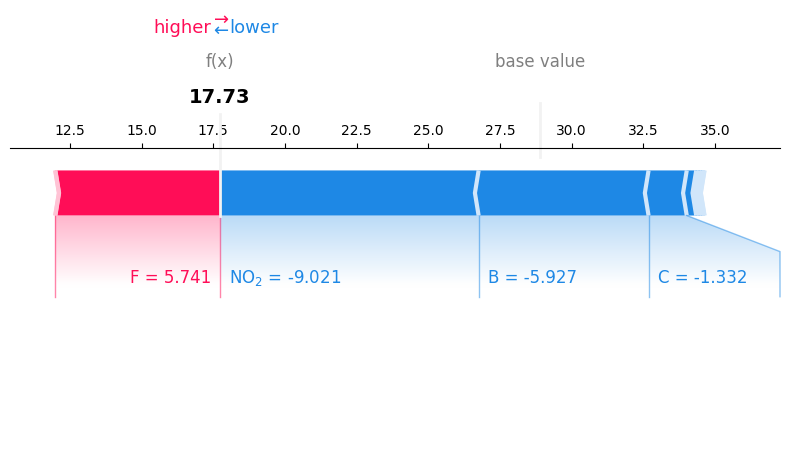

In [33]:
def prepare_aggregated_1d_shap_and_values(idxs, shap_C, shap_E, X_val):
    feature_names = [r"NO$_2$","A", "B", "C", "DEG", "F", "H", "I", "J", "KL"]
    NO2_shap = np.mean(shap_C[idxs, ..., 0], axis=0).reshape((1,))
    NOx_shap= np.mean(np.sum(shap_E[idxs, ..., :,:,:], axis = (1, 2)), axis=0).reshape((9,))
    all_shap_1d = np.concatenate([NO2_shap, NOx_shap]).reshape(10,)

    NO2_val = X_val[0].reshape(-1,1) #(1095,1)
    NO2_val = np.round(np.mean(NO2_val[idxs], axis=0), 3)
    NOx_val = np.round(np.mean(np.sum(X_val[1][idxs], axis=(1,2)), axis = 0), 3)
    all_val_1d = np.concatenate([NO2_val, NOx_val])

    return feature_names, all_shap_1d, all_val_1d

def plot_aggregated_forceplot(quantile, shap_C, shap_E, X_val, explainer, figsize = (15,5)):
    feature_names, all_shap_1d, all_val_1d = prepare_aggregated_1d_shap_and_values(quantile, shap_C, shap_E, X_val)
    fig = shap.plots.force(
        explainer.expected_value[0].numpy(),
        all_shap_1d,
        feature_names=feature_names,
        features=all_val_1d,
        matplotlib=True,
        show=False,
        figsize = figsize
        
    )

def denormalize_shap_and_predictions(shap_C, shap_E, y_pred, explainer):
    min, max = 8.56, 94.5397
    den_shap_E = shap_E * (max - min)
    den_shap_C = shap_C * (max - min)
    explainer_den = shap.DeepExplainer(model, background)
    explainer_den.expected_value = [explainer_den.expected_value[0] * (max - min) + min]
    den_y_pred = y_pred * (max - min) + min
    return den_shap_C, den_shap_E, den_y_pred, explainer_den

den_shap_C, den_shap_E, den_y_pred, explainer_den = denormalize_shap_and_predictions(shap_C, shap_E, y_pred, explainer)

quantile = 0.1
idxs = np.argsort(y_pred.flatten())[-int(quantile * len(y_pred)):]
print("Number of samples: ", len(idxs))
print(f"Force plot for the top {int(quantile*100):d}% predicted NO2 values (avg of y_pred = {np.mean(den_y_pred[idxs])}):")
plot_aggregated_forceplot(idxs, den_shap_C, den_shap_E, [den_shap_C, den_shap_E.reshape((1095, 45, 45, 9))], explainer_den, figsize = (8,5))
plt.tight_layout()
plt.savefig(f"../../figs/SHAP_forceplot_top_{int(quantile*100):d}.png", dpi=300)
plt.show()
idxs = np.argsort(y_pred.flatten())[:int(quantile * len(y_pred))]
print(f"Force plot for the bottom {int(quantile*100):d}% predicted NO2 values (avg of y_pred = {np.mean(den_y_pred[idxs])}):")
plot_aggregated_forceplot(idxs, den_shap_C, den_shap_E, [den_shap_C, den_shap_E.reshape((1095, 45, 45, 9))], explainer_den, figsize = (8,5))
plt.tight_layout()
plt.savefig(f"../../figs/SHAP_forceplot_bottom_{int(quantile*100):d}.png", dpi=300)
plt.show()

c:\Users\Gabriele\miniconda3\envs\codit2026\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


Force plot for the central 20% (50% +/- 10.0%) predicted NO2 values:


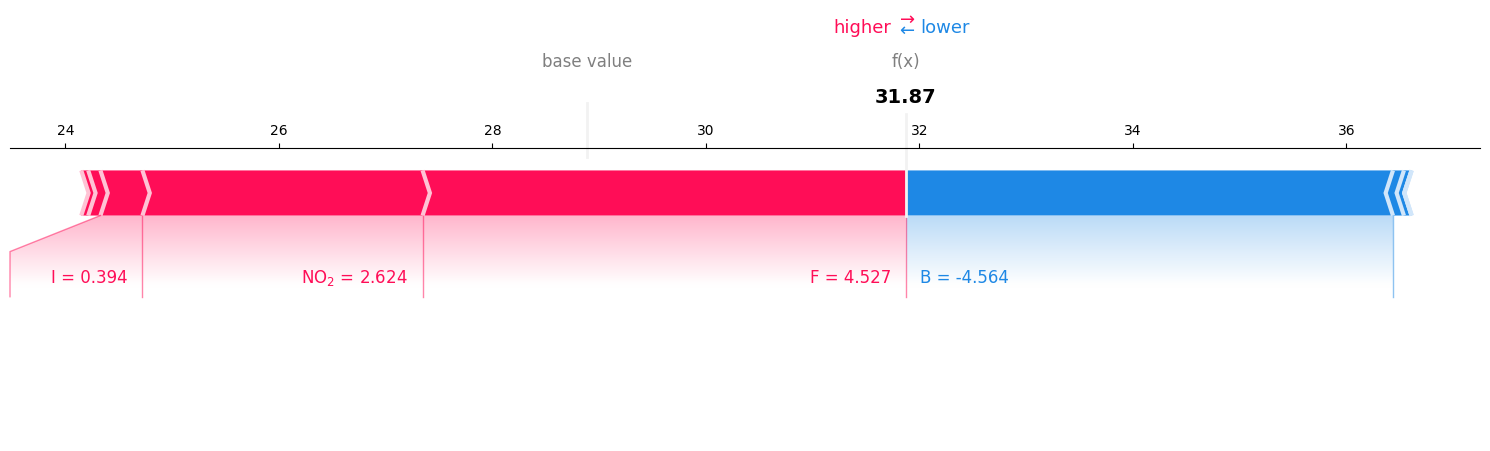

In [24]:
den_shap_C, den_shap_E, den_y_pred, explainer_den = denormalize_shap_and_predictions(shap_C, shap_E, y_pred, explainer)

quantile = 0.1
print(f"Force plot for the central {int(2*quantile*100):d}% (50% +/- {float(quantile*100):.1f}%) predicted NO2 values:")
idxs = np.argsort(den_y_pred.flatten())[int((0.5 - quantile) * len(den_y_pred)):int((0.5 + quantile) * len(den_y_pred))]
plot_aggregated_forceplot(idxs, den_shap_C, den_shap_E, [den_shap_C, den_shap_E.reshape((1095, 45, 45, 9))], explainer_den)
plt.tight_layout()
plt.show()

Force plot for the whole period 2020-2022:


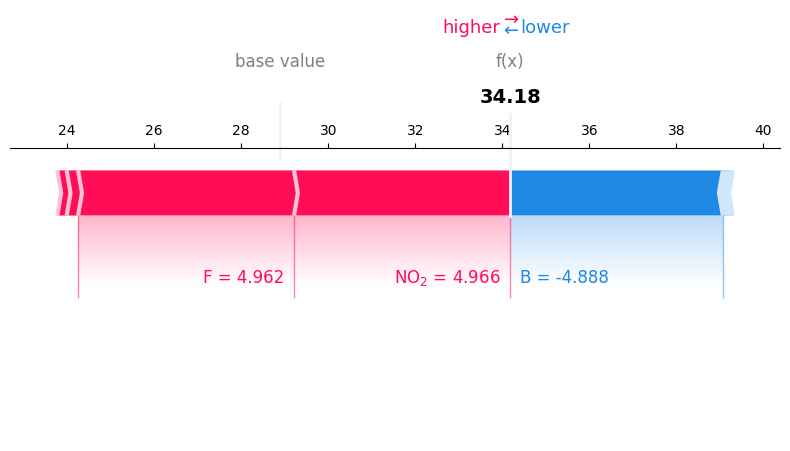

In [30]:
den_shap_C, den_shap_E, den_y_pred, explainer_den = denormalize_shap_and_predictions(shap_C, shap_E, y_pred, explainer)

quantile = 0.1
print(f"Force plot for the whole period 2020-2022:")
idxs = np.arange(len(y_pred))
plot_aggregated_forceplot(idxs, den_shap_C, den_shap_E, [den_shap_C, den_shap_E.reshape((1095, 45, 45, 9))], explainer_den, figsize = (8,5))
plt.tight_layout()
plt.savefig(f"../../figs/SHAP_forceplot_all.png", dpi=300)
plt.show()